In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from os import listdir
import plotly
import plotly.graph_objs as go
import kaleido
from mpl_toolkits.mplot3d import Axes3D

In [140]:
'''
First compute the 2d subspace at a specific time point. 
Then project the population activity matrix at all other time points onto this subspace. 

'''

subject = 'Tir'

info = 's2'
area = 'PFC'
condition = 'retain'
trial_num = 45
X = np.load(f'/om/user/huidili/wmUpdate/150b50s_decode/spk_dec_condition_data/{subject}/{subject}_{info}_{area}_{condition}_feature_label.npz')['feature']

In [141]:
data_t = np.load('/om/user/huidili/wmUpdate/150b50s_decode/spk_dec_input/061311Tir_spk_rate.npz')['rate_bins']
tps = np.mean(data_t, axis=1)

In [142]:
def pca_tp(popu_X_t):
    # pca
    cov = np.cov(popu_X_t.T)
    (U, S, VT) = np.linalg.svd(cov, full_matrices=False)
#     print(np.cumsum(S)/np.sum(S))
    Z_t = U[:,:2].T@popu_X_t.T
    return U, Z_t
    

In [143]:
def add_surface(start_t, end_t, ax_min, ax_max):
    x=[ax_min, ax_min, ax_max, ax_max, ax_min, ax_min, ax_max, ax_max]
    y=[ax_min, ax_max, ax_max, ax_min, ax_min, ax_max, ax_max, ax_min]
    z=[start_t, start_t, start_t, start_t, end_t, end_t, end_t, end_t]

    return go.Mesh3d(x=x,y=y,z=z, alphahull = 0, color='grey', opacity=0.1, showscale=False)

In [144]:
def t_to_idx(t):
    return int((t-(-2))/0.05)
def bind_z_t(Z_t, i):
    return np.expand_dims(np.concatenate((Z_t, np.array([tps[i]]*4).reshape(1,-1)), axis=0), axis=0)

In [145]:
def calculate_area(c):

    '''
    Calculates the area of any quadrivaletral
    from a list of x,y coordinates in the following format:

    [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    '''

    first = c[0][0]*c[1][1] + c[1][0]*c[2][1] + c[2][0]*c[3][1] + c[3][0]*c[0][1]

    second = c[1][0]*c[0][1] + c[2][0]*c[1][1] + c[3][0]*c[2][1] + c[0][0]*c[3][1]

    area = 0.5*(first - second)

    return np.abs(area)

In [146]:
# compute population matrix (separate mean for each neuron and time bin)

popu_X = []
for i in range(0, X.shape[0], trial_num):
    popu_X.append(np.expand_dims(np.mean(X[i:i+trial_num], axis=0), axis=0))
popu_X = np.concatenate(popu_X, axis=0)
popu_X_mean = np.expand_dims(np.mean(popu_X, axis=0), axis=0)
popu_X = popu_X - popu_X_mean

t_pca = 3
t_start = 2
t_end = 3


U, Z_t = pca_tp(popu_X[:,:,t_to_idx(t_pca)])

all_Z = []
for i in range(t_to_idx(t_start), t_to_idx(t_end)+1):
    Z = U[:,:2].T@popu_X[:,:,i].T
    print(calculate_area(Z.T))
    all_Z.append(bind_z_t(Z, i))
all_Z = np.concatenate(all_Z, axis=0)

84.86678277119151
85.72264565151208
95.79309610057058
75.54566840834823
45.159284793714825
10.608280670931382
8.879524947462766
15.075216475488183
18.445651524576665
32.843425033734334
97.47144002867729
87.91763050003256
62.59824001772815
30.035337192162576
81.44326153002912
149.93999157640846
314.27342560588716
493.9158539837596
794.1911092151165
996.1080253401861
1284.0073981938829


In [147]:
# # Configure Plotly to be rendered inline in the notebook.
# plotly.offline.init_notebook_mode()
if 'r' in info:
    labels = ['lowest reward', '2nd lowest reward', '2nd highest reward', 'highest reward']
else: 
    labels = ['45 deg', '135 deg', '225 deg', '315 deg']

# ax_min = -60
# ax_max = 60

# fig = go.Figure(data=[go.Scatter3d(x=all_Z[:,0,0], y=all_Z[:,1,0], z=all_Z[:,2,0], marker=dict(size=3, color='red'), line=dict(width=1, color='black'), name=labels[0]), go.Scatter3d(x=np.zeros_like(tps), y=np.zeros_like(tps), z=tps, mode='lines', name='central axis')])
# fig.add_trace(go.Scatter3d(x=all_Z[:,0,1], y=all_Z[:,1,1], z=all_Z[:,2,1], marker=dict(size=3, color='orange'), line=dict(width=1, color='black'), name=labels[1]))
# fig.add_trace(go.Scatter3d(x=all_Z[:,0,2], y=all_Z[:,1,2], z=all_Z[:,2,2], marker=dict(size=3, color='seagreen'), line=dict(width=1, color='black'), name=labels[2]))
# fig.add_trace(go.Scatter3d(x=all_Z[:,0,3], y=all_Z[:,1,3], z=all_Z[:,2,3], marker=dict(size=3, color='dodgerblue'), line=dict(width=1, color='black'), name=labels[3]))
# fig.add_trace(add_surface(0, 0.2, ax_min, ax_max))
# fig.add_trace(add_surface(0.8, 1, ax_min, ax_max))
# fig.add_trace(add_surface(1.6, 1.8, ax_min, ax_max))
# fig.add_trace(add_surface(2.4,2.6, ax_min, ax_max))
# fig.add_trace(add_surface(3.2, 3.20001, ax_min, ax_max))
# fig.update_layout(title_text=f'Representation of {info} in {area} for {subject} across time', title_x=0.45, scene_aspectmode='manual', scene_aspectratio=dict(x=1, y=1, z=8), scene=dict(xaxis=dict(range=[ax_min, ax_max], nticks=10, title='PC1'), yaxis=dict(range=[ax_min, ax_max], nticks=10, title='PC2'), zaxis=dict(title='Time (s)', ticktext=['S1', 'R1', 'S2', 'R2', 'Saccade'], tickvals=[0.1, 0.9, 1.7, 2.5, 3.2])))

# # fig.write_html('/om/user/huidili/wmUpdate/150b50s_decode/plots/interactive_plots/Tir_s1_PFC_retain.html')

# # Render the plot.
# plotly.offline.iplot(fig)

In [148]:
def plot_cube(ax, xylim, z_median):   
    phi = np.arange(1,10, 2)*np.pi/4
    Phi, Theta = np.meshgrid(phi, phi) 

    x = np.cos(Phi)*np.sin(Theta)
    y = np.sin(Phi)*np.sin(Theta)
    z = np.cos(Theta)/np.sqrt(2)
    x = x*xylim*2
    y = y*xylim*2
    z = z/5 + z_median
    ax.plot_surface(x, y, z, alpha=0.05, color='grey')

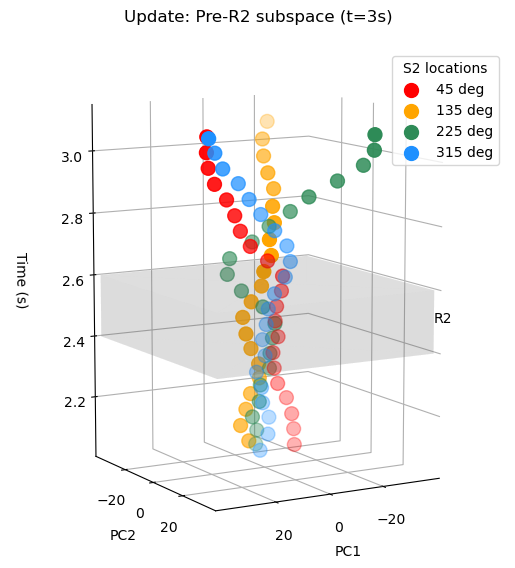

In [149]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(bottom=-2,top=10)
marker_size = 100
p = ax.scatter(all_Z[:,0,0], all_Z[:,1,0], all_Z[:,2,0], c='red', label=labels[0], s=marker_size)
ax.scatter(all_Z[:,0,1], all_Z[:,1,1], all_Z[:,2,1], c='orange', label=labels[1], s=marker_size)
ax.scatter(all_Z[:,0,2], all_Z[:,1,2], all_Z[:,2,2], c='seagreen', label=labels[2], s=marker_size)
ax.scatter(all_Z[:,0,3], all_Z[:,1,3], all_Z[:,2,3], c='dodgerblue', label=labels[3], s=marker_size)
ax.set_box_aspect((0.7, 0.7, 1))

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.set_xticks([-20,0,20])
ax.set_yticks([-20,0,20])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Time (s)', labelpad=20)
ax.set_title(f'Update: Pre-R2 subspace (t={t_pca}s)', pad=20)
xylim = 40
ax.set_xlim(-xylim, xylim)
ax.set_ylim(-xylim, xylim)


plot_cube(ax, xylim, 2.5)
ax.text(-40,40, 2.5, 'R2')


plt.legend(title='S2 locations')
ax.view_init(10, 60)
# fig.colorbar(p, ax=ax)